## 🎯 Learning Objectives

After working through this notebook, you will be able to:

1. **Generate and prepare synthetic data**  
   - Create a dataset that follows a linear trend with added Gaussian noise.  
   - Understand how true model parameters (slope $m$ and intercept $c$) are hidden in noisy data.

2. **Implement gradient descent for linear regression**  
   - Derive and apply update rules for slope ($m$) and intercept ($c$).  
   - Track parameter updates over multiple iterations.

3. **Evaluate model performance**  
   - Compute the Mean Squared Error (MSE) as a loss function:  
     $$
     L = \frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2
     $$
   - Observe how the loss decreases with each iteration.

4. **Visualize the learning process dynamically**  
   - Animate how the regression line evolves to fit the data points.  
   - Show projection lines between predictions and actual data to illustrate residuals.  
   - Plot the loss curve alongside parameter updates to connect intuition with metrics.

5. **Experiment with hyperparameters**  
   - Adjust learning rate, number of iterations, and initial parameter values to see their impact.  
   - Recognize signs of underfitting, slow convergence, or unstable training.

6. **Build intuition for linear regression with optimization**  
   - Relate gradient descent steps to minimizing errors.  
   - Understand how iterative optimization finds the best-fit line in practice.


# Fitting a line

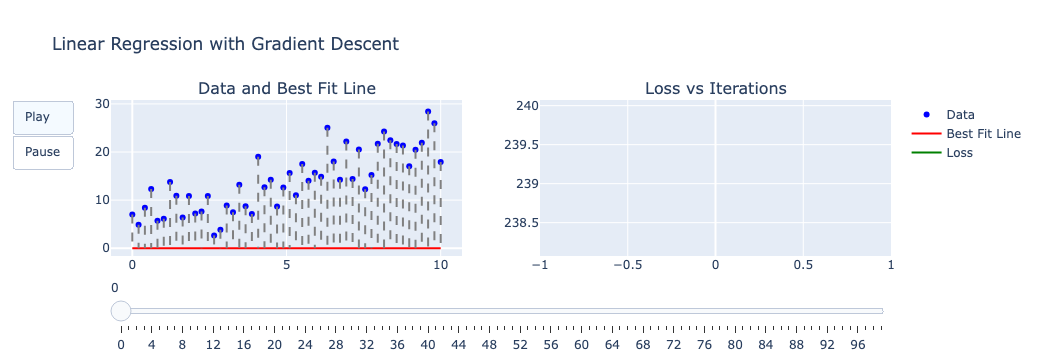

In [1]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ----------------------------
# Data Generation
# ----------------------------
def generate_data(m=2, c=3, n=50, noise=5, seed=42):
    np.random.seed(seed)
    X = np.linspace(0, 10, n)
    y = m * X + c + np.random.randn(n) * noise
    return X, y

# ----------------------------
# Gradient Descent
# ----------------------------
def gradient_descent(X, y, lr=0.001, iters=100, init_m=0, init_c=0):
    m, c = init_m, init_c
    n = len(y)
    losses, params = [], []

    for _ in range(iters):
        y_pred = m * X + c
        error = y_pred - y

        dm = (2/n) * np.dot(error, X)
        dc = (2/n) * np.sum(error)

        m -= lr * dm
        c -= lr * dc

        loss = np.mean(error**2)
        losses.append(loss)
        params.append((m, c, y_pred))
    return params, losses

# ----------------------------
# Parameters
# ----------------------------
true_m, true_c = 2, 5
noise = 4
n_points = 50
lr = 0.001
iterations = 100
init_m, init_c = 0, 0

X, y = generate_data(m=true_m, c=true_c, n=n_points, noise=noise)
params, losses = gradient_descent(X, y, lr=lr, iters=iterations,
                                  init_m=init_m, init_c=init_c)

# ----------------------------
# Helper: Build projection trace
# ----------------------------
def make_projection_trace(X, y, y_pred):
    x_proj, y_proj = [], []
    for xi, yi, ypi in zip(X, y, y_pred):
        x_proj += [xi, xi, None]
        y_proj += [yi, ypi, None]
    return x_proj, y_proj

# ----------------------------
# Initial traces (static + placeholders)
# ----------------------------
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Data and Best Fit Line", "Loss vs Iterations"))

# Trace 0 = static data points (will never change)
fig.add_trace(go.Scatter(x=X, y=y, mode='markers',
                         marker=dict(color='blue'), name='Data'),
              row=1, col=1)

# Trace 1 = best-fit line (animated)
fig.add_trace(go.Scatter(x=X, y=params[0][2], mode='lines',
                         line=dict(color='red'), name='Best Fit Line'),
              row=1, col=1)

# Trace 2 = projections (animated)
x_proj, y_proj = make_projection_trace(X, y, params[0][2])
fig.add_trace(go.Scatter(x=x_proj, y=y_proj, mode='lines',
                         line=dict(color='gray', dash='dash'),
                         showlegend=False),
              row=1, col=1)

# Trace 3 = loss curve (animated)
fig.add_trace(go.Scatter(x=[0], y=[losses[0]], mode='lines',
                         line=dict(color='green'), name='Loss'),
              row=1, col=2)

# ----------------------------
# Frames (update traces 1, 2, 3 only)
# ----------------------------
frames = []
for i, (m, c, y_pred) in enumerate(params):
    # Projections
    x_proj, y_proj = make_projection_trace(X, y, y_pred)

    frames.append(go.Frame(
        data=[
            go.Scatter(x=X, y=y_pred),              # updates trace 1
            go.Scatter(x=x_proj, y=y_proj),         # updates trace 2
            go.Scatter(x=list(range(i+1)), y=losses[:i+1])  # updates trace 3
        ],
        traces=[1, 2, 3],  # which traces to update
        name=str(i)
    ))

# ----------------------------
# Layout + Controls
# ----------------------------
fig.update_layout(
    title="Linear Regression with Gradient Descent",
    updatemenus=[{
        "type": "buttons",
        "buttons": [
            {"label": "Play", "method": "animate",
             "args": [None, {"frame": {"duration": 100, "redraw": True},
                             "fromcurrent": True}]},
            {"label": "Pause", "method": "animate",
             "args": [[None], {"frame": {"duration": 0, "redraw": False},
                               "mode": "immediate"}]}
        ],
    }],
    sliders=[{
        "steps": [{"args": [[str(i)], {"frame": {"duration": 0, "redraw": True},
                                        "mode": "immediate"}],
                   "label": str(i), "method": "animate"} for i in range(iterations)]
    }]
)

fig.frames = frames
fig.show()


# Fitting a plane

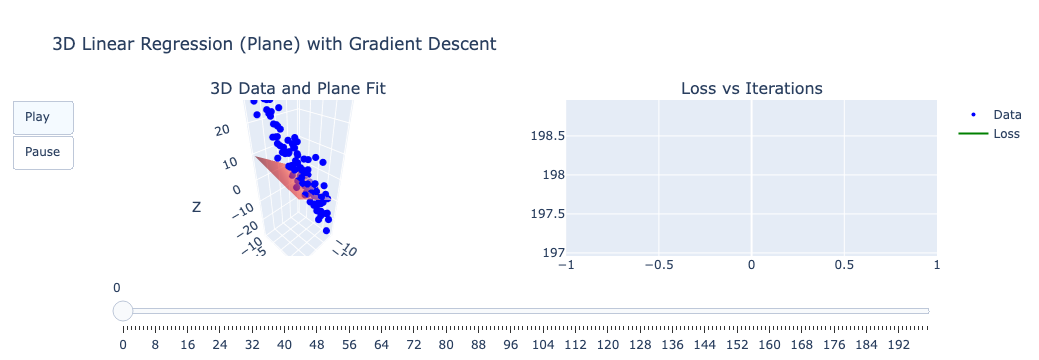

In [2]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ----------------------------
# Data Generation
# ----------------------------
def generate_data(a=2, b=1, c=5, n=100, noise=5, seed=42):
    np.random.seed(seed)
    X = np.random.uniform(-10, 10, n)
    Y = np.random.uniform(-10, 10, n)
    Z = a * X + b * Y + c + np.random.randn(n) * noise
    return X, Y, Z

# ----------------------------
# Gradient Descent for Plane z = a*x + b*y + c
# ----------------------------
def gradient_descent(X, Y, Z, lr=0.0001, iters=100, init_a=0, init_b=0, init_c=0):
    a, b, c = init_a, init_b, init_c
    n = len(Z)
    losses, params = [], []

    for _ in range(iters):
        Z_pred = a * X + b * Y + c
        error = Z_pred - Z

        # Gradients
        da = (2/n) * np.dot(error, X)
        db = (2/n) * np.dot(error, Y)
        dc = (2/n) * np.sum(error)

        a -= lr * da
        b -= lr * db
        c -= lr * dc

        loss = np.mean(error**2)
        losses.append(loss)
        params.append((a, b, c))
    return params, losses

# ----------------------------
# Parameters
# ----------------------------
true_a, true_b, true_c = 2, -1, 5
noise = 5
n_points = 100
lr = 0.005
iterations = 200
init_a, init_b, init_c = 0, 0, 0

# Generate data
X, Y, Z = generate_data(a=true_a, b=true_b, c=true_c,
                        n=n_points, noise=noise)
params, losses = gradient_descent(X, Y, Z, lr=lr, iters=iterations,
                                  init_a=init_a, init_b=init_b, init_c=init_c)

# Mesh grid for plane plotting
xx, yy = np.meshgrid(np.linspace(min(X), max(X), 20),
                     np.linspace(min(Y), max(Y), 20))

# ----------------------------
# Initial figure setup
# ----------------------------
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "scene"}, {"type": "xy"}]],
                    subplot_titles=("3D Data and Plane Fit", "Loss vs Iterations"))

# Static scatter (trace 0)
fig.add_trace(go.Scatter3d(x=X, y=Y, z=Z, mode='markers',
                           marker=dict(size=4, color='blue'), name="Data"),
              row=1, col=1)

# Dummy plane (trace 1)
zz0 = params[0][0] * xx + params[0][1] * yy + params[0][2]
fig.add_trace(go.Surface(x=xx, y=yy, z=zz0, colorscale="Reds",
                         opacity=0.6, showscale=False, name="Plane"),
              row=1, col=1)

# Dummy loss curve (trace 2)
fig.add_trace(go.Scatter(x=[0], y=[losses[0]], mode='lines',
                         line=dict(color='green'), name="Loss"),
              row=1, col=2)

# ----------------------------
# Animation frames
# ----------------------------
frames = []
for i, (a, b, c) in enumerate(params):
    zz = a * xx + b * yy + c
    frames.append(go.Frame(
        data=[
            go.Surface(x=xx, y=yy, z=zz, colorscale="Reds",
                       opacity=0.6, showscale=False),  # updates plane (trace 1)
            go.Scatter(x=list(range(i+1)), y=losses[:i+1])  # updates loss (trace 2)
        ],
        traces=[1, 2],
        name=str(i)
    ))

# ----------------------------
# Layout + Controls
# ----------------------------
fig.update_layout(
    title="3D Linear Regression (Plane) with Gradient Descent",
    scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"),
    updatemenus=[{
        "type": "buttons",
        "buttons": [
            {"label": "Play", "method": "animate",
             "args": [None, {"frame": {"duration": 100, "redraw": True},
                             "fromcurrent": True}]},
            {"label": "Pause", "method": "animate",
             "args": [[None], {"frame": {"duration": 0, "redraw": False},
                               "mode": "immediate"}]}
        ],
    }],
    sliders=[{
        "steps": [{"args": [[str(i)], {"frame": {"duration": 0, "redraw": True},
                                        "mode": "immediate"}],
                   "label": str(i), "method": "animate"} for i in range(iterations)]
    }]
)

fig.frames = frames
fig.show()


## Effect of regularization 

## 🎯 Learning Objectives

After working through this notebook, you will be able to:

1. **Understand the regression model being fit**  
   - The objective is to approximate the relationship:  
     $$
     y_i = \sum_{j=1}^{n} x_{ij} \theta_j + \varepsilon_i
     $$
     where $x_{ij}$ is the $j$-th feature of sample $i$, $\theta_j$ are the coefficients, and $\varepsilon_i$ is noise.  

2. **Understand the role of regularization in linear regression**  
   - Explain why overfitting occurs in high-dimensional settings.  
   - Compare no regularization (Ordinary Least Squares, OLS), L1 (Lasso), and L2 (Ridge) regression.

3. **Formulate regression with penalties**  
   - OLS objective:  
     $$
     \min_\theta \; \sum_{i=1}^m \left(y_i - \sum_{j=1}^{n} x_{ij} \theta_j \right)^2
     $$  

   - Ridge objective (L2):  
     $$
     \min_\theta \; \sum_{i=1}^m \left(y_i - \sum_{j=1}^{n} x_{ij} \theta_j \right)^2 \;+\; 
     \lambda \sum_{j=1}^{n} \theta_j^2
     $$  

   - Lasso objective (L1):  
     $$
     \min_\theta \; \sum_{i=1}^m \left(y_i - \sum_{j=1}^{n} x_{ij} \theta_j \right)^2 \;+\; 
     \lambda \sum_{j=1}^{n} |\theta_j|
     $$  

4. **Generate and explore synthetic dense data**  
   - Create datasets where all features have non-zero contributions.  
   - Understand how noise and feature dimensionality affect regression.

5. **Fit and compare models across $\lambda$ values**  
   - Observe how increasing $\lambda$ changes the learned coefficients.  
   - Compare the sparsity induced by L1 vs. the shrinkage effect of L2.  
   - Contrast both with OLS (no penalty).

6. **Visualize coefficient paths interactively**  
   - Use animated bar plots to track coefficient magnitudes as $\lambda$ varies.  
   - Interpret differences in feature selection and weight scaling.

7. **Build intuition for model selection**  
   - Recognize when Lasso is useful for feature selection (sparse solutions).  
   - Recognize when Ridge is more stable for correlated features.  
   - Understand trade-offs between bias and variance under different regularization schemes.


In [24]:
import numpy as np
from sklearn.linear_model import Lasso, Ridge, LinearRegression
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ----------------------------
# Synthetic Data Generation
# ----------------------------
def generate_dense_data(m=100, n=30, noise=0.1, seed=42):
    """
    Generate synthetic dense linear regression data:
    y = Xθ + ε
    """
    np.random.seed(seed)
    X = np.random.randn(m, n)  # m samples, n features
    
    # Dense true parameters θ (all non-zero)
    theta_true = np.random.uniform(-3, 3, n)
    
    y = X @ theta_true + np.random.randn(m) * noise
    return X, y, theta_true

# ----------------------------
# Fit models for a given λ
# ----------------------------
def fit_models(X, y, lam):
    # L1 (Lasso)
    lasso = Lasso(alpha=lam, fit_intercept=False, max_iter=5000)
    lasso.fit(X, y)
    theta_l1 = lasso.coef_
    
    # No regularization (OLS)
    ols = LinearRegression(fit_intercept=False)
    ols.fit(X, y)
    theta_ols = ols.coef_
    
    # L2 (Ridge)
    ridge = Ridge(alpha=lam, fit_intercept=False)
    ridge.fit(X, y)
    theta_l2 = ridge.coef_
    
    return theta_l1, theta_ols, theta_l2

# ----------------------------
# Data
# ----------------------------
X, y, theta_true = generate_dense_data(m=100, n=30, noise=1.0)

# Feature labels
feature_names = [f"x{j+1}" for j in range(X.shape[1])]

# ----------------------------
# Prepare slider frames
# ----------------------------
lambda_values = np.logspace(-3, 2, 20)  # 0.001 → 100
frames = []

for lam in lambda_values:
    theta_l1, theta_ols, theta_l2 = fit_models(X, y, lam)
    
    frames.append(go.Frame(
        data=[
            go.Bar(x=feature_names, y=theta_l1, marker_color="red"),
            go.Bar(x=feature_names, y=theta_ols, marker_color="blue"),
            go.Bar(x=feature_names, y=theta_l2, marker_color="green"),
        ],
        name=f"{lam:.4f}"
    ))

# ----------------------------
# Initial model fit
# ----------------------------
theta_l1, theta_ols, theta_l2 = fit_models(X, y, lambda_values[0])

# ----------------------------
# Figure layout
# ----------------------------
fig = make_subplots(rows=3, cols=1,
                    subplot_titles=("L1 Regularization (Lasso)",
                                    "No Regularization (OLS)",
                                    "L2 Regularization (Ridge)"))

# Initial coefficient bars
fig.add_trace(go.Bar(x=feature_names, y=theta_l1, marker_color="red"), row=1, col=1)
fig.add_trace(go.Bar(x=feature_names, y=theta_ols, marker_color="blue"), row=2, col=1)
fig.add_trace(go.Bar(x=feature_names, y=theta_l2, marker_color="green"), row=3, col=1)

# ----------------------------
# Slider setup
# ----------------------------
steps = []
for lam in lambda_values:
    steps.append(dict(
        method="animate",
        args=[[f"{lam:.4f}"], {"frame": {"duration": 500, "redraw": True},
                               "mode": "immediate"}],
        label=f"{lam:.4f}"
    ))

sliders = [dict(
    active=0,
    steps=steps,
    currentvalue={"prefix": "Lambda: "}
)]

fig.update_layout(
    title="Effect of L1 vs L2 Regularization on Dense Parameters θ",
    sliders=sliders,
    height=900,
    showlegend=False
)

fig.frames = frames
fig.show()


## 🎯 Learning Objectives

After working through this notebook, you will be able to:

1. **Understand polynomial regression with high-degree features**  
   - The model attempts to approximate:  
     $$
     y_i \approx \sum_{j=0}^{n} \theta_j \, x_i^j + \varepsilon_i
     $$  
     where $n$ is the polynomial degree, $\theta_j$ are the parameters, and $\varepsilon_i$ is noise.

2. **Recognize overfitting in high-degree models**  
   - Explain why large-degree polynomials ($n=21$ in this case) can fit the training data perfectly but generalize poorly.  
   - Identify visual signs of overfitting in polynomial regression.

3. **Formulate regression objectives with penalties**  
   - OLS (no regularization):  
     $$
     \min_\theta \; \sum_{i=1}^m \left( y_i - \sum_{j=0}^{n} \theta_j x_i^j \right)^2
     $$
   - Ridge (L2 regularization):  
     $$
     \min_\theta \; \sum_{i=1}^m \left( y_i - \sum_{j=0}^{n} \theta_j x_i^j \right)^2 + \lambda \sum_{j=0}^{n} \theta_j^2
     $$
   - Lasso (L1 regularization):  
     $$
     \min_\theta \; \sum_{i=1}^m \left( y_i - \sum_{j=0}^{n} \theta_j x_i^j \right)^2 + \lambda \sum_{j=0}^{n} |\theta_j|
     $$

4. **Visualize the effect of regularization on polynomial fits**  
   - Compare OLS, Ridge, and Lasso curves on the same noisy dataset.  
   - Observe how Ridge smooths the curve by shrinking coefficients, while Lasso can set some coefficients exactly to zero.

5. **Experiment with $\lambda$ interactively**  
   - Use a log-scale slider to adjust $\lambda$ across several orders of magnitude.  
   - Explore how small $\lambda$ leads to overfitting, while large $\lambda$ enforces smoother, simpler models.

6. **Build intuition for model complexity control**  
   - Understand how regularization acts as a safeguard against overfitting in polynomial regression.  
   - Learn the trade-off between bias and variance as $\lambda$ changes.


In [ ]:
import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import make_pipeline
import ipywidgets as widgets
from ipywidgets import interact

# --- Generate sample data ---
np.random.seed(42)
x = np.linspace(0, 10, 20)
y = (x - 5) ** 3 + 3 * (x - 6) ** 2
noise = np.random.normal(0, 16, y.shape)
y = y + noise
X = x.reshape(-1, 1)

deg = 21

# --- OLS (λ=0, no regularization) ---
ols = make_pipeline(
    PolynomialFeatures(degree=deg),
    StandardScaler(with_mean=False),
    LinearRegression()
)
ols.fit(X, y)
y_pred_ols = ols.predict(X)

# --- Function to update plot based on λ ---
def plot_with_lambda(lam=0.0):
    if lam == 0:
        y_pred_ridge = y_pred_ols
        y_pred_lasso = y_pred_ols
    else:
        ridge = make_pipeline(
            PolynomialFeatures(degree=deg),
            StandardScaler(with_mean=False),
            Ridge(alpha=lam)
        )
        ridge.fit(X, y)
        y_pred_ridge = ridge.predict(X)

        lasso = make_pipeline(
            PolynomialFeatures(degree=deg),
            StandardScaler(with_mean=False),
            Lasso(alpha=lam, max_iter=200000)
        )
        lasso.fit(X, y)
        y_pred_lasso = lasso.predict(X)

    # Build interactive plot
    fig = go.Figure()

    # Data points
    fig.add_trace(go.Scatter(x=x, y=y, mode='markers',
                             name='Data', marker=dict(color='black')))

    # OLS baseline
    fig.add_trace(go.Scatter(x=x, y=y_pred_ols, mode='lines',
                             name='OLS', line=dict(color='blue')))

    # Ridge curve
    fig.add_trace(go.Scatter(x=x, y=y_pred_ridge, mode='lines',
                             name=f'L2', line=dict(color='green')))

    # Lasso curve
    fig.add_trace(go.Scatter(x=x, y=y_pred_lasso, mode='lines',
                             name=f'L1', line=dict(color='red')))

    fig.update_layout(
        template="plotly_white",
        title=f"Polynomial Regression with Ridge & Lasso (λ={lam})",
        xaxis_title="x",
        yaxis_title="y",
        autosize=False,
        width=800,   # same width
        height=600,   # same height
        margin=dict(l=60, r=40, t=60, b=60)
    )
    fig.show()

# --- Interactive slider ---
interact(plot_with_lambda, lam=widgets.FloatLogSlider(
    value=0.0,
    base=10,
    min=-2,  # 10^-2 = 0.01
    max=3,   # 10^3 = 1000
    step=0.01,
    description="λ (lambda)"
))


interactive(children=(FloatLogSlider(value=0.01, description='λ (lambda)', max=3.0, min=-2.0, step=0.01), Outp…

<function __main__.plot_with_lambda(lam=0.0)>